In [1]:
# !pip install opencv-python
# !pip install glob2
# !pip install seaborn
# !pip install opencv-contrib-python-headless
# !pip install scikit-image
# !pip install scikit-learn
# !pip install tabulate

In [2]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pretrained_models.xceptionnet import XceptionNet as PretrainedModel
from pypackage.classifier import Classifier
from pypackage.preprocessor import Preprocessor
from pypackage.feature_extractor import FeatureExtractor

2023-02-01 23:29:17.593517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load and Resize data

In [3]:
# Read input images and assign labels based on folder names
SIZE = 224  # Resize images

In [4]:
# Capture training data and labels into respective lists
train_images = []
train_labels = []

for directory_path in glob.glob("../datasets/Training/*"):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        # print(img_path)
        img = cv2.imread(img_path, 
                 cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        train_images.append(img)
        train_labels.append(label)

# Convert lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

['glioma' 'meningioma' 'no_tumor' 'pituitary']
[1321 1339 1595 1457]


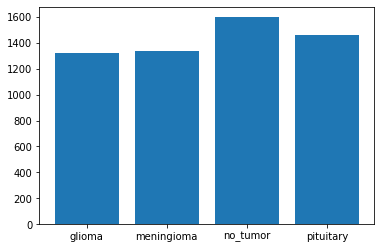

In [5]:
classes, counts = np.unique(train_labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(classes))
print(classes)
print(counts)

In [6]:
# Capture test/validation data and labels into respective lists
test_images = []
test_labels = []

for directory_path in glob.glob("../datasets/Testing/*"):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label)

# Convert lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

['glioma' 'meningioma' 'no_tumor' 'pituitary']
[300 306 405 300]


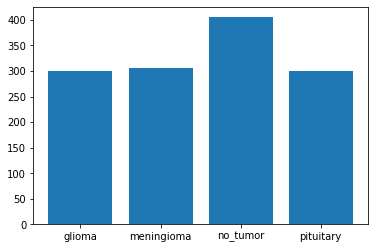

In [7]:
classes, counts = np.unique(test_labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(classes))
print(classes)
print(counts)

### Data Augmentation

#### Train dataset

In [8]:
# flip left-right direction
da_train_images = np.append( train_images, [ np.fliplr(x) for x in train_images], axis=0 )
da_train_labels = np.append( train_labels, [ x for x in train_labels] )

# flip up-down direction
da_train_images = np.append( da_train_images, [ np.flipud(x) for x in train_images], axis=0 )
da_train_labels = np.append( da_train_labels, [ x for x in train_labels] )

# add salt and pepper noise
da_train_images = np.append( da_train_images, [ Preprocessor.addNoise(cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)) for x in train_images], axis=0 )
da_train_labels = np.append( da_train_labels, [ x for x in train_labels] )

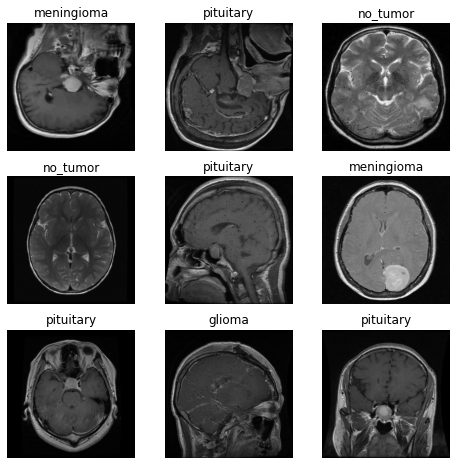

In [9]:
plt.figure(figsize=(8, 8))
for i, idx in enumerate(np.random.randint(da_train_images.shape[0], size=9), start=1):
    plt.subplot(3, 3, i)
    plt.imshow( da_train_images[idx], cmap='gray')
    plt.title(str(da_train_labels[idx]))
    plt.axis('off')

['glioma' 'meningioma' 'no_tumor' 'pituitary']
[5284 5356 6380 5828]


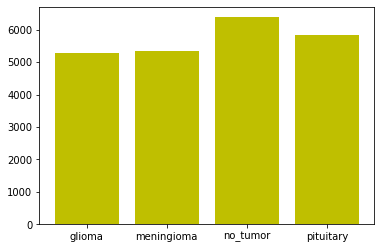

In [10]:
classes, counts = np.unique(da_train_labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(classes),
        width = 0.8, color = ['y'])
print(classes)
print(counts)

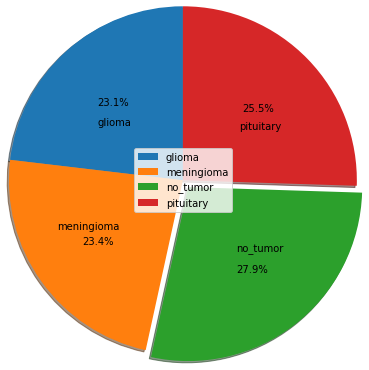

In [11]:
# color for each label
colors = ['r', 'y', 'g', 'b']
plt.pie(counts, labels = classes, labeldistance=0.45,
        startangle=90, shadow = True, explode = (0, 0, 0.1, 0),
        radius = 2, autopct = '%1.1f%%')
  
# plotting legend
plt.legend(loc='center')
  
# showing the plot
plt.show()

#### Test dataset

In [12]:
# flip left-right direction
da_test_images = np.append( test_images, [ np.fliplr(x) for x in test_images], axis=0 )
da_test_labels = np.append( test_labels, [ x for x in test_labels] )

# flip up-down direction
da_test_images = np.append( da_test_images, [ np.flipud(x) for x in test_images], axis=0 )
da_test_labels = np.append( da_test_labels, [ x for x in test_labels] )

# add salt and pepper noise
da_test_images = np.append( da_test_images, [ Preprocessor.addNoise(cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)) for x in test_images], axis=0 )
da_test_labels = np.append( da_test_labels, [ x for x in test_labels] )

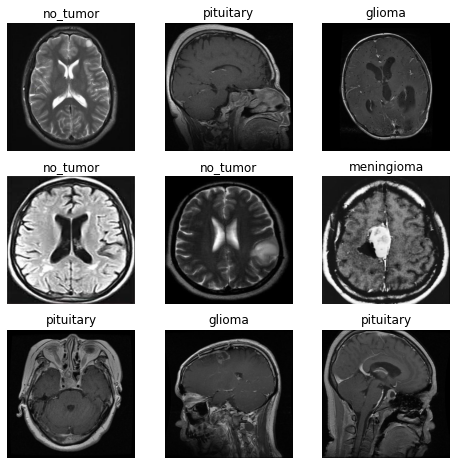

In [13]:
plt.figure(figsize=(8, 8))
for i, idx in enumerate(np.random.randint(da_test_images.shape[0], size=9), start=1):
    plt.subplot(3, 3, i)
    plt.imshow( da_test_images[idx], cmap='gray')
    plt.title(str(da_test_labels[idx]))
    plt.axis('off')

['glioma' 'meningioma' 'no_tumor' 'pituitary']
[1200 1224 1620 1200]


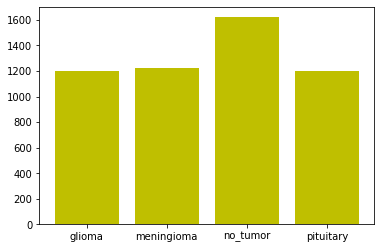

In [14]:
classes, counts = np.unique(da_test_labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(classes),
        width = 0.8, color = ['y'])
print(classes)
print(counts)

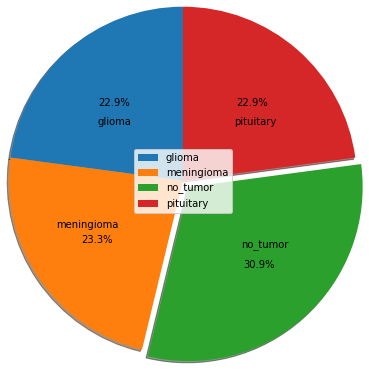

In [15]:
# color for each label
colors = ['r', 'y', 'g', 'b']
plt.pie(counts, labels = classes, labeldistance=0.45,
        startangle=90, shadow = True, explode = (0, 0, 0.1, 0),
        radius = 2, autopct = '%1.1f%%')
  
# plotting legend
plt.legend(loc='center')
  
# showing the plot
plt.show()

### Encode labels

In [16]:
# Encode labels from text to integers.
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(da_test_labels)
test_labels_encoded = le.transform(da_test_labels)
le.fit(da_train_labels)
train_labels_encoded = le.transform(da_train_labels)

In [17]:
# Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = (
    da_train_images,
    train_labels_encoded,
    da_test_images,
    test_labels_encoded,
)

In [18]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [19]:
# One hot encode y values for neural network.
from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

### Load model, preprocess input and extract features

In [20]:
# Load model without classifier/fully connected layers
model = PretrainedModel.build(SIZE)

2023-02-01 23:31:22.978030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [21]:
# preprocess the train input
x_train = PretrainedModel.preprocess(x_train)

In [22]:
# Now, let us use features from convolutional network
train_ft = FeatureExtractor.extract(model, x_train)

714/714 [==============================] - 1975s 3s/step


In [23]:
# preprocess the train input
x_test = PretrainedModel.preprocess(x_test)

In [24]:
# Send test data through same feature extractor process
test_ft = FeatureExtractor.extract(model, x_test)

164/164 [==============================] - 445s 3s/step


### Random Forest classifier

In [25]:
# Prediction from Random Forest classifier
pred_RF = Classifier.RF(train_ft, test_ft, y_train)

# Inverse le transform to get original label back.
pred_RF = le.inverse_transform(pred_RF)

# Print accuracy, precision, fscore
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score

test_labels = da_test_labels
RF_Accuracy = accuracy_score(test_labels, pred_RF)
RF_Precision = precision_score(test_labels, pred_RF, average='weighted')
RF_Fscore = f1_score(test_labels, pred_RF, average='weighted')

print("RF_Accuracy = ", RF_Accuracy, "RF_Precision = ", RF_Precision, "RF_Fscore = ", RF_Fscore)

RF_Accuracy =  0.9323035850495804 RF_Precision =  0.9335906117557012 RF_Fscore =  0.9312976305309428


[[ 965  170    3   62]
 [  53 1127   15   29]
 [   0    0 1620    0]
 [   7   12    4 1177]]


<AxesSubplot:>

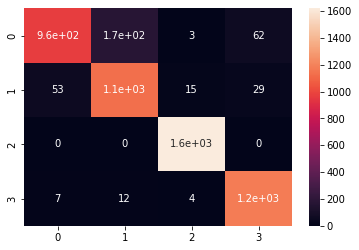

In [26]:
# Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(test_labels, pred_RF)
print(cm)
sns.heatmap(cm, annot=True)

### Naive Bayes classifier

In [27]:
# Prediction from Naive Bayes classifier
pred_NB = Classifier.NB(train_ft, test_ft, y_train)

# Inverse le transform to get original label back.
pred_NB = le.inverse_transform(pred_NB)

# Print accuracy, precision, fscore

NB_Accuracy = accuracy_score(test_labels, pred_NB)
NB_Precision = precision_score(test_labels, pred_NB, average='weighted')
NB_Fscore = f1_score(test_labels, pred_NB, average='weighted')

print("NB_Accuracy = ", NB_Accuracy, "NB_Precision = ", NB_Precision, "NB_Fscore = ", NB_Fscore)

NB_Accuracy =  0.4797864225781846 NB_Precision =  0.6132376222639434 NB_Fscore =  0.4696377136879807


[[1139   24    7   30]
 [ 738  338   22  126]
 [ 446  287  702  185]
 [ 861    1    1  337]]


<AxesSubplot:>

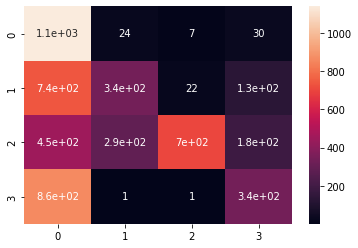

In [28]:
# Confusion Matrix - verify accuracy of each class

cm = confusion_matrix(test_labels, pred_NB)
print(cm)
sns.heatmap(cm, annot=True)

### Logistic Regression classifier

In [29]:
# Prediction from Logistic Regression classifier
pred_LR = Classifier.LR(train_ft, test_ft, y_train)

# Inverse le transform to get original label back.
pred_LR = le.inverse_transform(pred_LR)

# Print accuracy, precision, fscore

LR_Accuracy = accuracy_score(test_labels, pred_LR)
LR_Precision = precision_score(test_labels, pred_LR, average='weighted')
LR_Fscore = f1_score(test_labels, pred_LR, average='weighted')

print("LR_Accuracy = ", LR_Accuracy, "LR_Precision = ", LR_Precision, "LR_Fscore = ", LR_Fscore)

/Users/oluwasetty/.virtualenvs/dis_lpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR_Accuracy =  0.7145308924485125 LR_Precision =  0.7108613170302429 LR_Fscore =  0.7108810215060001


[[ 752  322   25  101]
 [ 192  623  211  198]
 [  65  103 1357   95]
 [  64   84   37 1015]]


<AxesSubplot:>

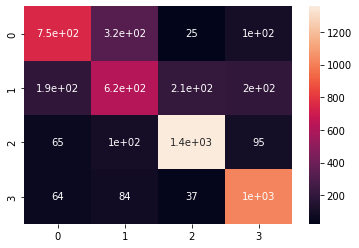

In [30]:
# Confusion Matrix - verify accuracy of each class

cm = confusion_matrix(test_labels, pred_LR)
print(cm)
sns.heatmap(cm, annot=True)

### K Nearest Neighbors classifier

In [31]:
# Prediction from K Nearest Neighbors classifier
pred_KNN = Classifier.KNN(train_ft, test_ft, y_train)

# Inverse le transform to get original label back.
pred_KNN = le.inverse_transform(pred_KNN)

# Print accuracy, precision, fscore

KNN_Accuracy = accuracy_score(test_labels, pred_KNN)
KNN_Precision = precision_score(test_labels, pred_KNN, average='weighted')
KNN_Fscore = f1_score(test_labels, pred_KNN, average='weighted')

print("KNN_Accuracy = ", KNN_Accuracy, "KNN_Precision = ", KNN_Precision, "KNN_Fscore = ", KNN_Fscore)

KNN_Accuracy =  0.9324942791762014 KNN_Precision =  0.931884396527478 KNN_Fscore =  0.9316748158379059


[[1036  114    2   48]
 [  86 1058   36   44]
 [   6    4 1606    4]
 [   4    6    0 1190]]


<AxesSubplot:>

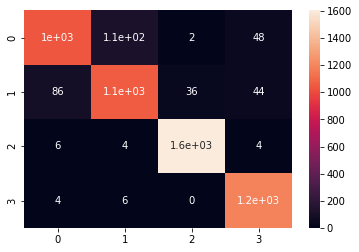

In [32]:
# Confusion Matrix - verify accuracy of each class

cm = confusion_matrix(test_labels, pred_KNN)
print(cm)
sns.heatmap(cm, annot=True)

### Decision Tree classifier

In [33]:
# Prediction from Decision Tree classifier
pred_DT = Classifier.DT(train_ft, test_ft, y_train)

# Inverse le transform to get original label back.
pred_DT = le.inverse_transform(pred_DT)

# Print accuracy, precision, fscore

DT_Accuracy = accuracy_score(test_labels, pred_DT)
DT_Precision = precision_score(test_labels, pred_DT, average='weighted')
DT_Fscore = f1_score(test_labels, pred_DT, average='weighted')

print("DT_Accuracy = ", DT_Accuracy, "DT_Precision = ", DT_Precision, "DT_Fscore = ", DT_Fscore)

DT_Accuracy =  0.5602593440122045 DT_Precision =  0.5748666443302322 DT_Fscore =  0.5032018480327929


[[ 750   20   89  341]
 [ 572   43  222  387]
 [ 192    6 1251  171]
 [ 121    6  179  894]]


<AxesSubplot:>

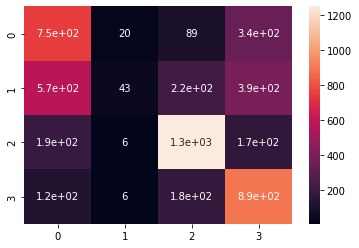

In [34]:
# Confusion Matrix - verify accuracy of each class

cm = confusion_matrix(test_labels, pred_DT)
print(cm)
sns.heatmap(cm, annot=True)

### Performance Metrics

In [35]:
from tabulate import tabulate

In [36]:
# create data
data = [
    ["RF", RF_Accuracy, RF_Precision, RF_Fscore],
    ["NB", NB_Accuracy, NB_Precision, NB_Fscore],
    ["LR", LR_Accuracy, LR_Precision, LR_Fscore],
    ["DT", DT_Accuracy, DT_Precision, DT_Fscore],
    ["KNN", KNN_Accuracy, KNN_Precision, KNN_Fscore],
]

# define header names
col_names = ["Classifier", "Accuracy", "Precision", "F1-score"]

# display table
print(tabulate(data, headers=col_names, tablefmt="rounded_grid"))

Classifier      Accuracy    Precision    F1-score
------------  ----------  -----------  ----------
RF              0.932304     0.933591    0.931298
NB              0.479786     0.613238    0.469638
LR              0.714531     0.710861    0.710881
DT              0.560259     0.574867    0.503202
KNN             0.932494     0.931884    0.931675


In [39]:
np.save("Extracted features/xceptiontrain", train_ft)

In [2]:
np.save("Extracted features/xceptiontest", test_ft)

NameError: name 'np' is not defined